In this notebook we will be writing our first CA simulator code, which we will subsequently build off of to demonstrate various aspects of scientific programming in Python. The code here will use no abstraction through functions or classes, and will not use any numpy. We will try our best though to follow the PEP8 style guide and make this code as readable as we can. 

Below we use the jupyter notebook as a development workspace, where we can try various approaches and run small tests to make sure code we write is doing what we want it to do. At the end we will collect all the pieces and put them in a single cell which will act as our code base script. Executing that cell will produce and plot a spacetime field of a given shape using the given ECA rule number.

First thing is to import all packages we will be using, which here is just the random package for random initial conditions and matplotlib to plot spacetime fields.
The last line is a ["magic"](https://ipython.readthedocs.io/en/stable/interactive/magics.html) command that renders plots in the output cell.

In [1]:
import random
from matplotlib import pyplot as plt
%matplotlib inline

A CA spacetime field is uniquely determined by the initial condition, the update rule (known as the "lookup table"), the number of time steps the update rule is applied, and the boundary conditions. 

We will only use periodic boundary conditions so the three pieces we need for the simulator are an initial condition, the number of time steps, and the lookup table. 

Let's start by producing a random binary string of a given length for our initial condition.

In [2]:
length = 20

There are several ways to create our initial condition without using numpy.

In [3]:
# first, let's create an empty list and then build it up with random samples of (0,1)
initial_condition_1 = []
for i in range(length):
    initial_condition_1.append(random.randint(0,1))
print(initial_condition_1)

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]


The above is intuitive, but since it has to dynamically allocate memory space to the initial condition list as it grows it is not as efficient as it could be (it doesn't really make much of a difference for such a small array, but it is good to start thinking about what is going on under-the-hood in this way). 

In [4]:
# next then, we can create a list of the given length, then populate it with random samples as so. 
initial_condition_2 = [0] * length 
for i in range(length):
    initial_condition_2[i] = random.randint(0,1)
print(initial_condition_2)

[1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]


The more Pythonic way to do this is by using what is called a list comprehension

In [5]:
initial_condition_3 = [random.randint(0,1) for _ in range(length)]
print(initial_condition_3)

[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


Create a variable for how many time steps to evolve our CA. 

In [6]:
time = 20

Those were easy. Now we have to make the lookup table, which is less trivial. It may not be immediately obvious what data structure we should use for this. The lookup table maps neighborhoods to updated site values, so we will use a dictionary which maps keys to values. 

Dictionaries are the built-in implementation of [hash tables](https://en.wikipedia.org/wiki/Hash_table#In_programming_languages) in Python.

The lookup table is defined by the CA rule number, following the Wolfram numbering convention: the eight possible neighborhood values are given in lexicographical order and the corresponding lookup table outputs for the neighborhoods (in order) are treated as the binary representation of an integer, which is the CA rule number. 

So first we need to convert our integer rule number to binary. We also need a list of the 8 possible neighborhoods given in lexicographical order. Since these will be the keys for our lookup table dictionary, they need to be tuples

In [7]:
rule_number = 18

In [8]:
# list of neighborhood values, given as tuples, in lexicographical order
neighborhoods = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

In [9]:
# first we will try bin() to convert the rule number to binary
print(bin(rule_number))
# cut off the fisrt two characters (0b), and flip the remaining string around so it is the proper order
print(bin(rule_number)[2:][::-1]) 

0b10010
01001


Notice that the result is not 8 characters long. We need to pad it with zeros on the right so that all the neighborhoods have an output they map to. 

In [10]:
# A simple, but not Pythonic, first thing we could do is this
in_binary_1 = bin(rule_number)[2:][::-1]
binary_length = len(in_binary_1)
if binary_length != 8:
    padding = 8 - binary_length
    in_binary_1 = in_binary_1 + '0'*padding
print(in_binary_1)

01001000


We can now build the lookup table dictionary

In [11]:
lookup_table_1 = {}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary_1[i]
    lookup_table_1.update({key:val})
for key, val in lookup_table_1.items():
    print(key, '-->', val)

(0, 0, 0) --> 0
(0, 0, 1) --> 1
(0, 1, 0) --> 0
(0, 1, 1) --> 0
(1, 0, 0) --> 1
(1, 0, 1) --> 0
(1, 1, 0) --> 0
(1, 1, 1) --> 0


We can do both of the above steps in a more Pythonic way using a try, except statement. This way we don't need to pad the binary conversion, since we know if there is an index error it would needed to be padded with 0. 

In [12]:
# if we try to create the dictionary without padding we get an IndexError
in_binary_2 = bin(rule_number)[2:][::-1]
lookup_table_2 ={}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary_2[i]
    lookup_table_2.update({key:val})

IndexError: string index out of range

In [13]:
# use try, except statement to make val a 0 if the index runs over, where we had to pad before
in_binary_2 = bin(rule_number)[2:][::-1]
lookup_table_2 ={}
for i in range(8):
    key = neighborhoods[i]
    try:
        val = in_binary_2[i]
    except IndexError:
        val = '0'
    lookup_table_2.update({key: val})
for key, val in lookup_table_2.items():
    print(key, '-->', val)

(0, 0, 0) --> 0
(0, 0, 1) --> 1
(0, 1, 0) --> 0
(0, 1, 1) --> 0
(1, 0, 0) --> 1
(1, 0, 1) --> 0
(1, 1, 0) --> 0
(1, 1, 1) --> 0


Better still, let's use string formatting to convert the rule number to binary and automatically pad with 0s as needed, then use zip and dict to create the lookup table.

In [14]:
in_binary_3 = '{:{fill}{align}{width}b}'.format(rule_number, fill='0', align='>', width='8')
print(in_binary_3)

00010010


since the string formatting also gives the binary result in the opposite order of what we want, use the reversed function in zip, so that it iterates through in the order we need

### This is the Pythonic way of implementing a CA lookup table using a dictionary.

In [15]:
lookup_table_3 = dict(zip(neighborhoods, reversed(in_binary_3)))

for key, val in lookup_table_3.items():
    print(key, '-->', val)

(0, 0, 0) --> 0
(0, 0, 1) --> 1
(0, 1, 0) --> 0
(0, 1, 1) --> 0
(1, 0, 0) --> 1
(1, 0, 1) --> 0
(1, 1, 0) --> 0
(1, 1, 1) --> 0


note that because we use string formatting to create the binary representation of the rule number, the lookup table outputs are strings, and we will convert them to ints later

In [16]:
print(type(lookup_table_3[(0,0,0)]))

<class 'str'>


We now have all the pieces we need, so let's put them together to make a spacetime field

spacetime field will be a list of lists, so that spacetime_field[t] is the lattice configuration at time t initialize with the initial condition

In [17]:
spacetime_field = [initial_condition_3]

In [18]:
print(spacetime_field)
print(spacetime_field[0]) 
print(spacetime_field[0] == initial_condition_3) # spacetime field at time 0 should be the initial condition

[[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]]
[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
True


for implementation of the update rule, we will need a variable to keep track of the current configuration

In [19]:
# We have to be careful though to COPY the list, and not just use the equals sign (which just sets a new pointer)
current_configuration = initial_condition_3.copy()

In [20]:
print(current_configuration)

[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


we will also need a new_configuration placeholder 

In [21]:
new_configuration = []

now iterate through the current configuration, get the neighborhood, and apply the lookup table

In [22]:
for i in range(len(current_configuration)):
    
    neighborhood = (current_configuration[(i-1)], 
                    current_configuration[i], 
                    current_configuration[(i+1)%length]) # use % for periodic boundary condition
    
    new_configuration.append(int(lookup_table_3[neighborhood]))
print(new_configuration)

[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


now the do the same as above for the given number of time steps

In [23]:
for t in range(time):
    new_configuration = []
    for i in range(len(current_configuration)):
        
        neighborhood = (current_configuration[(i-1)], 
                        current_configuration[i], 
                        current_configuration[(i+1)%length])
        
        new_configuration.append(int(lookup_table_3[neighborhood]))
    # update the current configuration    
    current_configuration = new_configuration # here we don't want to keep making new copies, so use '='
    # add the new configuration to the spacetime field
    spacetime_field.append(new_configuration)

Take a look out our spacetime field

In [24]:
for config in spacetime_field:
    print(config)

[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
[1, 0, 1, 0, 1, 0, 1, 0,

Finally, make a spacetime diagram

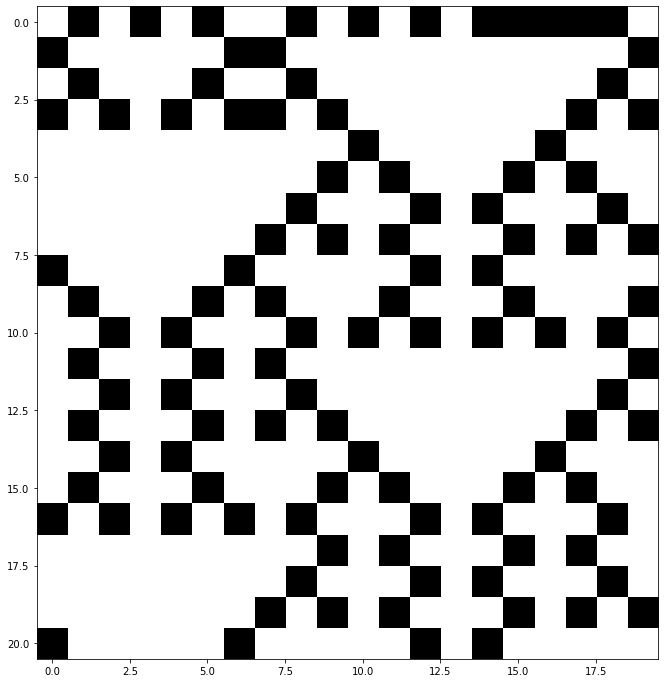

In [25]:
plt.figure(figsize=(12,12))
plt.imshow(spacetime_field, cmap=plt.cm.Greys, interpolation='nearest')
plt.show()

Looks like rule 18!

We now collect all the final results so that we can run everything in a single cell (like a .py script) to chose our parameters and create the corresponding spacetime diagram. 

To maximize spaghettiness and make it look gross, I'm going to use the non-pythonic implementations from above, so if you are skipping down to this part be sure to go back up and see some better code.

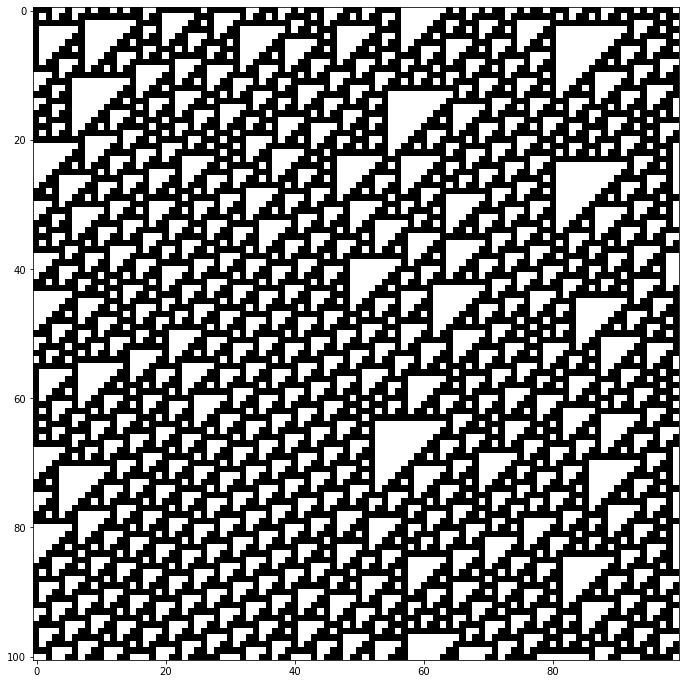

In [26]:
rule_number = 110
length = 100
time = 100 

# make the initial condition
initial_condition = []
for i in range(length):
    initial_condition.append(random.randint(0,1))

# create list of neighborhood tuples in lex. order
neighborhoods = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

# convert the rule number to binary and padd with 0s as needed
in_binary = bin(rule_number)[2:][::-1]
binary_length = len(in_binary)
if binary_length != 8:
    padding = 8 - binary_length
    in_binary = in_binary + '0'*padding

# create the lookup table dictionary
lookup_table = {}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary[i]
    lookup_table.update({key:val})
    
# initialize spacetime field and current configuration
spacetime_field = [initial_condition]
current_configuration = initial_condition.copy()

# apply the lookup table to evolve the CA for the given number of time steps
for t in range(time):
    new_configuration = []
    for i in range(len(current_configuration)):
        
        neighborhood = (current_configuration[(i-1)%length], 
                        current_configuration[i], 
                        current_configuration[(i+1)%length])
        
        new_configuration.append(int(lookup_table[neighborhood]))
        
    current_configuration = new_configuration
    spacetime_field.append(new_configuration)
    
# plot the spacetime field diagram
plt.figure(figsize=(12,12))
plt.imshow(spacetime_field, cmap=plt.cm.Greys, interpolation='nearest')
plt.show()

## Final thoughts for the first tutorial

When getting started it is best to first and foremost write code that does what you want it to. There can be many different ways of writing code that produces the same output; we implemented a CA lookup table using a dictionary a few different ways in this notebook. There are "better" ways of writing code to produce the desired functionality. For scientific programming with Python, there are two things to keep in mind for what makes code "good". 

First, Python is a high-level language that allows for elegant, simple, and readible code. This is encapsulated in the Zen of Python, shown below. A few examples of good Python practices were shown in this notebook. Notice that we have used descriptive variable names like "rule_number" and "initial_condition", rather than using generic variable names like "x", "y", and "z". This makes code more readible and self-documenting. Code written this way is much easier to understand by others, and by yourself if you haven't looked at it for weeks, months, or years. Hardcoding of values should be avoided, though we have not always done so here, e.g. 'for i in range(8):'. Explicit indexing into lists, strings, tuples, etc. should similarly be avoided where possible. This is something we have done in the above, but will remove later with the use numpy arrays.

Second, your mathematical intuition can help to get code that works, but it may not always correspond to efficient implementations. Scientific computing is often very compute intensive, and efficient low-level languages like C and Fortran are popular for the speed they can achieve. High-level langauges, like Python, are generally much slower in contrast. We will discuss speed and performance further in the tutorials on Numpy and Numba. Even when writing native Python though, it is useful to think about performance and efficiency. For example, CA evolution happens iteratively, one step at a time. Thus the code written above intuitively applies the lookup table and then adds the new configuration into the spacetime field list at each time step. Python allows this, and it makes it easy to write this first version of the code that will produce spacetime fields as we desire. However, it is not very efficient. Memory must be dynamically allocated to the spacetime field list, as needed, when new configurations are appended. As we will do later, it is more efficient to first allocate the appropriate memory space, and then populate it. We can do this because we specify at the outset how many time steps we wish to evolve for. 


Finally, don't expect (or even necessarily try) to write the "correct" or "best" version of your program on the first try. Good code often takes several iterations. Making your code modular by using functions and classes, as described more in the next tutorial, as well as using unit tests will make it easier to modify and improve your code. Using version control, like [git](https://git-scm.com/book/en/v2) is also highly encouraged. 

In [ ]:
# avoid explicit indexing where possible in Python

List = [1,2,3]
# instead of this:
for i in range(len(List)):
    print(List[i])
    
# do this
for thing in List:
    print(thing)

In [28]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
